# Assignment 1
02689 Advanced Numerical Methods for Differential Equations
- Jeppe Klitgaard <`s250250@dtu.dk`>
- Tymoteusz Barcinski <`s221937@dtu.dk`>
- Pernille Christie <`s204249@dtu.dk`>

In [1]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import time
import math

sns.set_theme(style="whitegrid")

## 1 Fourier Methods
### a - Truncated Fourier Expansion

### b - Convergence Behaviour of Discrete Fourier Coefficients

### c - Nodal Expansion

### d - Fourier Differentiation Routine

### e - Convergence in the $L^2$-norm

### f - Numerical Differentiation using Fast Fourier Transform

## 2 Polynomial Methods
### h - Jacobi Polynomials

In [2]:
def a(alpha, beta, n1, n2):
    """Calculate a values for given alpha, beta and n 
    - last entry must be equal to n-1, n or n+1"""

    if n1 == n2 - 1 and n2 > 0:
        return (2 * (n2 + alpha) * (n2 + beta)) / (
            (2 * n2 + alpha + beta + 1) * (2 * n2 + alpha + beta)
        )
    elif n1 == n2:
        return (alpha**2 - beta**2) / (
            (2 * n2 + alpha + beta + 2) * (2 * n2 + alpha + beta)
            )
    elif n1 == n2 + 1:
        return (2 * n1 * (n1 + alpha + beta)) / (
            (2 * n2 + alpha + beta + 2) * (2 * n2 + alpha + beta + 1)
            )
    elif n1 == -1 and n2 == 0:
        return 0
    else:
        raise ValueError("Invalid n1,n2")
        
        
def JacobiP(x, alpha, beta, n):
    x = np.asarray(x)

    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return 0.5 * (alpha - beta + (alpha + beta + 2) * x)

    # Start values
    Pnm2 = np.ones_like(x)                                  # P_0
    Pnm1 = 0.5 * (alpha - beta + (alpha + beta + 2) * x)    # P_1

    # Iterate recurrence
    for k in range(2, n + 1):
        num = ( (a(alpha,beta,k-1,k-1) + x) * Pnm1
               - a(alpha,beta,k-2,k-1) * Pnm2 )
        denom = a(alpha,beta,k,k-1)
        Pn = num / denom
        Pnm2, Pnm1 = Pnm1, Pn

    return Pnm1

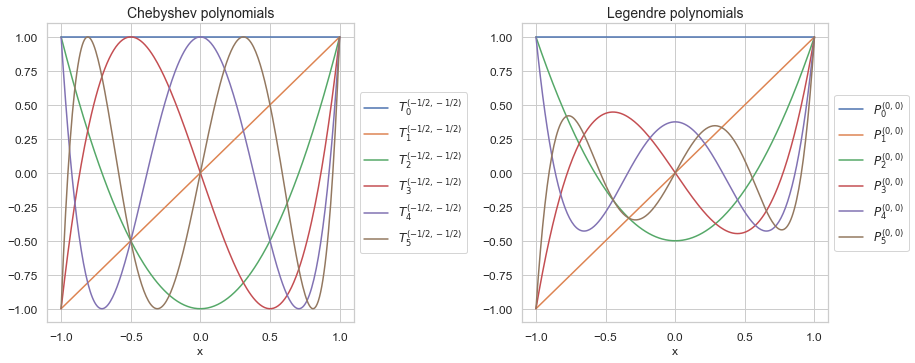

In [3]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5.5))

x = np.linspace(-1, 1, 250)

for n in range(6):
    axs[0].plot(x, scipy.special.gamma(n+1)* scipy.special.gamma(1/2) / scipy.special.gamma(n+1/2) * JacobiP(x, -1/2, -1/2, n), label=fr"$T_{n}^{{(-1/2, -1/2)}}$")
    axs[1].plot(x, JacobiP(x, 0, 0, n), label=fr"$P_{n}^{{(0,0)}}$")


axs[0].set_title("Chebyshev polynomials", fontsize=14)
axs[1].set_title("Legendre polynomials", fontsize=14)
axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)


for ax in axs:
    ax.tick_params(axis="both", labelsize=12)
    ax.set_xlabel("x", fontsize=12)

plt.subplots_adjust(wspace=0.55)

plt.savefig("report/output/2h_jacobi_polynomials.png", dpi=600, bbox_inches="tight")

### i - Numerical Experiments

In [4]:
def JacobiGQ(alpha, beta, N):
    """Translated code given by APEK"""
    
    if N == 0:
        x = np.array([-(alpha-beta)/(alpha+beta+2)])
        w = np.array([2])

        return x, w
    
    J = np.zeros((N+1, N+1), dtype=float)

    # Form symmetric matrix from recurrence.
    h1 = 2*np.arange(N+1) + alpha + beta
    J = np.diag(-1/2*(alpha**2 - beta**2) / (h1+2) / h1) 

    off_diag = 2.0 / (h1[:-1] + 2) * np.sqrt(
        (np.arange(1, N + 1) * (np.arange(1, N + 1) + alpha + beta) *
         (np.arange(1, N + 1) + alpha) * (np.arange(1, N + 1) + beta)) /
        ((h1[:-1] + 1) * (h1[:-1] + 3))
    )

    J += np.diag(off_diag, 1)

    if (alpha + beta < 10*np.finfo(float).eps):
        J[0, 0] = 0.0

    J = J + J.T

    D, V = np.linalg.eigh(J)   # eigh ensures real symmetric matrix handling
    x = D

    w = (V[0, :]**2) * 2**(alpha + beta + 1) / (alpha + beta + 1) \
        * scipy.special.gamma(alpha + 1) * scipy.special.gamma(beta + 1) / scipy.special.gamma(alpha + beta + 1)
    
    return x, w

def JacobiGL(alpha, beta, N):
    x = np.zeros(N+1, dtype=float)

    if N == 1:
        x = np.array([-1, 1])

        return x
    
    xint, _ = JacobiGQ(alpha + 1, beta + 1, N-2)

    x = np.concatenate((np.array([-1]), xint, np.array([1])))

    return x

In [5]:
def CalculateCoefficients(N, K, u):
    """Calculate all K coefficients for grid of size N, for a function given by u"""

    # Quadrature points
    x = JacobiGL(0, 0, N)
    # Quadrature weights
    w = 2 / (N * (N+1)) / np.power(JacobiP(x, 0, 0, N), 2)

    u_samples = u(x)

    # Precompute Jacobi polynomials for all k=0..K-1
    # Shape: (K, len(x))
    Phi = np.vstack([JacobiP(x, 0, 0, k) for k in range(K)])

    # Compute gamma_k for all k at once
    gamma = np.sum(Phi**2 * w, axis=1)

    # Compute numerator = <u, phi_k> for all k
    numerators = np.sum((u_samples * Phi) * w, axis=1)

    return numerators / gamma

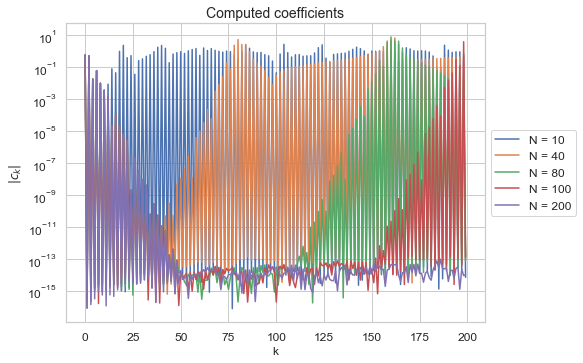

In [6]:
# Calculate all coefficients
K = 200
Ns = [10, 40, 80, 100, 200]

def u(x):
    return 1.0 / (2.0 - np.cos(np.pi*(x + 1)))
    # return np.sin(2*np.pi*(x + 0.1))

coefficients = np.zeros((len(Ns), K), dtype = float)


for (i, N) in enumerate(Ns):
    coefficients[i, :] = CalculateCoefficients(N, K, u)


# Plot absolte vale of all coefficients
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.5))

for i in range(len(Ns)):
    ax.plot(abs(coefficients[i]), label = f"N = {Ns[i]}")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
ax.set_xlabel("k", fontsize=12)
ax.set_ylabel(r"$|c_k|$", fontsize=12)
ax.set_title("Computed coefficients", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.set_yscale('log')

plt.savefig("report/output/2i_coefficients.png", dpi=600, bbox_inches="tight")

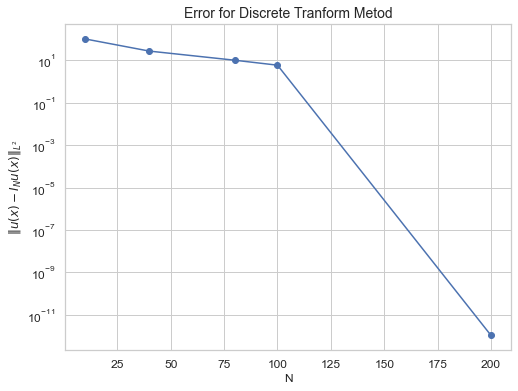

In [7]:
# Plot errors
fig, ax = plt.subplots(1, 1, figsize=(8,6))

xs = np.linspace(-1, 1, 250)

Phi = np.vstack([JacobiP(xs, 0, 0, k) for k in range(K)])

u_samples = u(xs)

errors = np.zeros_like(Ns, dtype=float)

for i in range(len(Ns)):
    u_approx = coefficients[i] @ Phi
    
    errors[i] = np.linalg.norm(u_samples - u_approx)


ax.plot(Ns, errors, '-o')
ax.set_xlabel("N", fontsize=12)
ax.set_ylabel(r"$\|u(x) - I_N u(x)\|_{L^2}$", fontsize=12)
ax.set_title("Error for Discrete Tranform Metod", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.set_yscale('log')
plt.savefig("report/output/2i_error_DTM.png", dpi=600)

### j - Generalized Vandermonde Matrix

In [8]:
def VandermondeMatrix(N):
    """Calculate the transposed Vandermonde Matrix for grid of size N"""

    # Calculate abscissus
    xN = JacobiGL(0, 0, N-1)

    VT = np.zeros((N, N), dtype = float)

    # Calculate the Jacobi polynomials for each column of transposed Vandermonde
    for n in range(N):
        VT[n, :] = JacobiP(xN, 0, 0, n)

    return VT

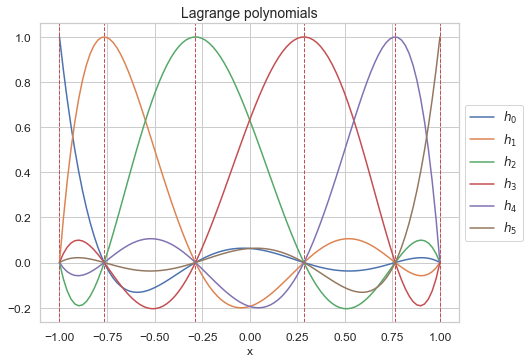

In [9]:
N = 6
nodes = 100

xN = JacobiGL(0, 0, N-1)

xunif = np.linspace(-1, 1, nodes)

phis = np.zeros((N, nodes), dtype = float)

# Evaluate each jaobi polynomial on the uniform grid
for n in range(N):
    phis[n] = JacobiP(xunif, 0, 0, n)

VT = VandermondeMatrix(N)

hs = np.zeros((N, nodes), dtype=float)

# Solve the equation system for each grid value
for i in range(nodes):
    hs[:, i] = np.linalg.solve(VT, phis[:, i])


# Plot resulting Lagrange polynomials and gridpoints
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.5))
for n in range(N):
    ax.plot(xunif, hs[n], label=fr"$h_{n}$")
    ax.axvline(x = xN[n], color = 'r', ls = '--', lw = 1)


ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
ax.set_xlabel("x", fontsize=12)
ax.set_title("Lagrange polynomials", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
plt.savefig("report/output/2k_lagrange_polynomials.png", dpi=600, bbox_inches="tight")

In [10]:
# Calculate approximations of v

def v(x):
    return np.sin(np.pi * x)

Ns = np.arange(1, 50, 5)

v_exact = v(xunif)

errors = np.zeros_like(Ns, dtype = float)

v_approx = np.zeros((len(Ns), nodes), dtype=float)

for (j, N) in enumerate(Ns):
    # Calculate DPT coefficients v_hat
    K = N+1
    
    v_hat = CalculateCoefficients(N, K, v)

    # Calculate Vandermonde matrix
    VT = VandermondeMatrix(N+1)

    Phi_unif = np.zeros((N+1, nodes), dtype = float)

    for n in range(N + 1):
        Phi_unif[n] = JacobiP(xunif, 0, 0, n)

    # From DFT coefficients calculate polynomial representation coefficients
    v_lag = VT.T @ v_hat

    # Calculate Lagrange polynomials as before
    hs = np.zeros((N+1, nodes), dtype=float)

    for i in range(nodes):
        hs[:, i] = np.linalg.solve(VT, Phi_unif[:, i])

    # Calculate error
    v_approx[j] = np.sum(hs * v_lag[:, None], axis=0)
    errors[j] = np.linalg.norm(v_exact - v_approx[j])

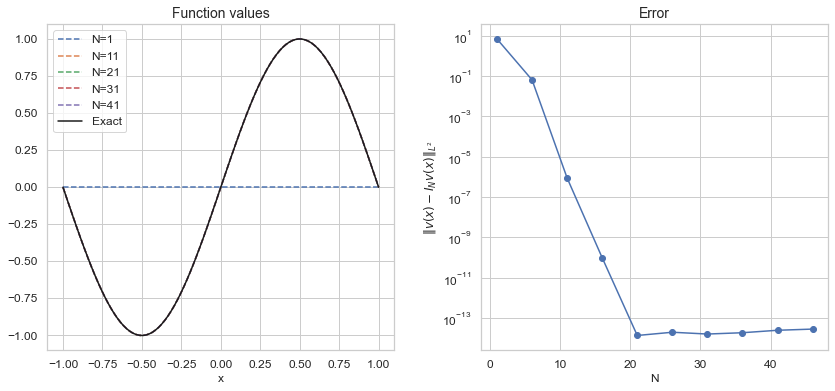

In [11]:
# Plot interpolant vs exact solution and errors
fig, ax = plt.subplots(1, 2, figsize=(14,6))

for i in range(0, len(Ns), 2):
    ax[0].plot(xunif, v_approx[i], '--', label=f"N={Ns[i]}")


ax[0].plot(xunif, v_exact, 'k', label="Exact")
ax[0].legend(fontsize=12)
ax[0].set_title("Function values", fontsize=14)
ax[0].set_xlabel("x")

ax[1].plot(Ns, errors, '-o')
ax[1].set_title("Error", fontsize=14)
ax[1].set_yscale('log')
ax[1].set_xlabel("N")
ax[1].set_ylabel(r"$\|v(x) - I_N v(x)\|_{L^2}$", fontsize=12)


for axis in ax:
    axis.tick_params(axis="both", labelsize=12)

plt.subplots_adjust(wspace=0.25)

plt.savefig("report/output/2k_errors.png", dpi=600)

In [12]:
# To extrapolate, we reuse the code, but change the uniform grid
Ns = np.arange(1, 50, 5)

nodes = 150

xunif = np.linspace(-1.5, 1.5, nodes)

v_exact = v(xunif)

errors = np.zeros_like(Ns, dtype = float)

v_approx = np.zeros((len(Ns), nodes), dtype=float)

for (j, N) in enumerate(Ns):
    # Calculate DPT coefficients v_hat
    K = N+1
    
    v_hat = CalculateCoefficients(N, K, v)

    # Calculate Vandermonde matrix
    VT = VandermondeMatrix(N+1)

    Phi_unif = np.zeros((N+1, nodes), dtype = float)

    for n in range(N + 1):
        Phi_unif[n] = JacobiP(xunif, 0, 0, n)

    # From DFT coefficients calculate polynomial representation coefficients
    v_lag = VT.T @ v_hat

    # Calculate Lagrange polynomials
    hs = np.zeros((N+1, nodes), dtype=float)

    for i in range(nodes):
        hs[:, i] = np.linalg.solve(VT, Phi_unif[:, i])

    # Calculate error
    v_approx[j] = np.sum(hs * v_lag[:, None], axis=0)
    errors[j] = np.linalg.norm(v_exact - v_approx[j])   

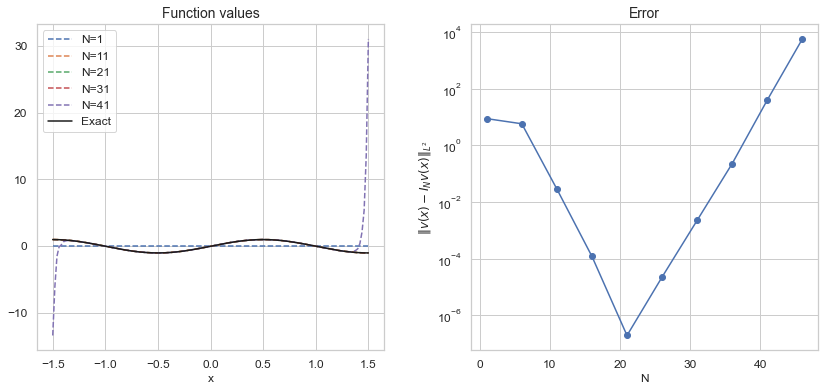

In [13]:
# Plot interpolant vs exact solution and errors
fig, ax = plt.subplots(1, 2, figsize=(14,6))

for i in range(0, len(Ns)-1, 2):
    ax[0].plot(xunif, v_approx[i], '--', label=f"N={Ns[i]}")


ax[0].plot(xunif, v_exact, 'k', label="Exact")
ax[0].legend(fontsize=12)
ax[0].set_title("Function values", fontsize=14)
ax[0].set_xlabel("x")

ax[1].plot(Ns, errors, '-o')
ax[1].set_title("Error", fontsize=14)
ax[1].set_yscale('log')
ax[1].set_xlabel("N")
ax[1].set_ylabel(r"$\|v(x) - I_N v(x)\|_{L^2}$", fontsize=12)


for axis in ax:
    axis.tick_params(axis="both", labelsize=12)

plt.subplots_adjust(wspace=0.25)

plt.savefig("report/output/2k_errors_extended.png", dpi=600)

### k - Derivative of Jacobi Polynomials

### l - Mass Matrix